In [1]:
import torch
import tensorflow as tf
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset
import os
from PIL import Image
import numpy as np
from tqdm import tqdm

# Define paths and parameters
base_image_folder_path = '/local_dir'
train_image_folder = os.path.join(base_image_folder_path, 'Train_Images')
test_image_folder = os.path.join(base_image_folder_path, 'Test_Images')
vector_model_name = 'openpecha/tibetan_RoBERTa_S_e6'
dataset_name = 'ta4tsering/Lhasa_kanjur_transcription_datasets'
image_height = 64
image_width = 2048

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(vector_model_name)
model = AutoModel.from_pretrained(vector_model_name).to('cuda')

def load_transcription_vector(transcription):
    inputs = tokenizer(transcription, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda')
    with torch.no_grad():
        outputs = model(**inputs)
    vector = torch.mean(outputs.last_hidden_state, dim=1).squeeze()
    return vector.cpu().numpy()

def load_image(folder_path, filename):
    img_path = os.path.join(folder_path, filename)
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = img.resize((image_width, image_height))
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return img.astype(np.float32)

def process_example(folder_path, example):
    transcription = example['label']
    filename = example['filename']
    if filename in local_filenames:
        vector = load_transcription_vector(transcription)
        image = load_image(folder_path, filename)
        return vector, image
    else:
        return None

def create_tf_dataset(split_name, folder_path):
    # Get the list of local filenames
    global local_filenames
    local_filenames = set(os.listdir(folder_path))

    # Load the dataset
    dataset = load_dataset(dataset_name, split=split_name)

    # Process the dataset using a for-loop
    vectors = []
    images = []

    for example in tqdm(dataset):
        result = process_example(folder_path, example)
        if result is not None:
            vector, image = result
            vectors.append(vector)
            images.append(image)

    # Convert lists to numpy arrays
    vectors = np.array(vectors, dtype=np.float32)
    images = np.array(images, dtype=np.float32)
    print("hi")
    # Create TensorFlow datasets directly from NumPy arrays
    tf_dataset = tf.data.Dataset.from_tensor_slices((vectors, images)).batch(1).cache().prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return tf_dataset

# Create datasets
#train_dataset = create_tf_dataset('train', train_image_folder)
eval_dataset = create_tf_dataset('eval', train_image_folder)
test_dataset = create_tf_dataset('test', test_image_folder)

2024-07-20 11:12:54.637767: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-20 11:12:54.650402: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-20 11:12:54.654801: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-20 11:12:54.665510: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of RobertaModel were not initialized fro

hi


2024-07-20 11:14:43.806043: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43184 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:41:00.0, compute capability: 8.9
100%|██████████| 16640/16640 [01:39<00:00, 166.47it/s]


hi


In [45]:
from tensorflow.keras.layers import Dense, Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the decoder model
def build_decoder(input_shape, vector_shape):
    # Decoder
    text_input = Input(shape=vector_shape)
    x = Dense(1024, activation='relu')(text_input)
    x = Dense(2048, activation='relu')(x)
    x = Dense(input_shape[0] * input_shape[1], activation='sigmoid')(x)
    decoded = Reshape(input_shape)(x)

    # Decoder model
    decoder = Model(text_input, decoded)
    decoder.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss='mse')

    return decoder

# Define the input shape and vector shape
input_shape = (image_height, image_width, 1)
vector_shape = (768,)  # Adjust based on the actual vector size from your text embeddings

# Build the decoder model
decoder = build_decoder(input_shape, vector_shape)
decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │       787,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 131072)         │   268,566,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 64, 2048, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,453,184 (1.01 GB)

 Trainable params: 271,453,184 (1.01 GB)

 Non-trainable params: 0 (0.00 B)

In [46]:
decoder.fit(test_dataset.take(1000), validation_data=eval_dataset.take(5), epochs=100, verbose=1)

Epoch 1/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - loss: 0.1142 - val_loss: 0.1042
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.1012 - val_loss: 0.1040
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.1009 - val_loss: 0.1039
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.1006 - val_loss: 0.1037
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.1003 - val_loss: 0.1036
Epoch 6/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0999 - val_loss: 0.1037
Epoch 7/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0993 - val_loss: 0.1036
Epoch 8/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0987 - val_loss: 0.1039
Epoch 9/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0979 - val_loss: 0.1044
Epoch 10/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.0971 - val_loss: 0.1048
Epoch 11/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.0962 - val_loss: 0.10


KeyboardInterrupt



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


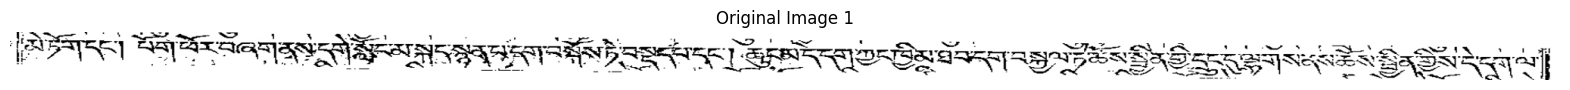

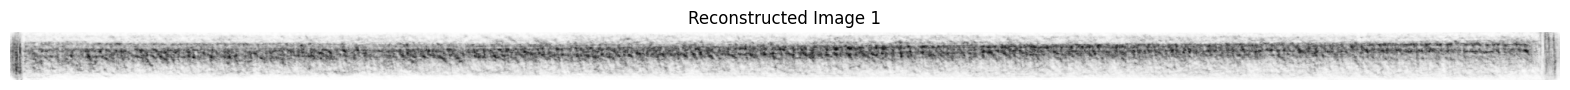

In [47]:
import matplotlib.pyplot as plt

# Function to plot image
def plot_image(image_array, title):
    plt.imshow(image_array.squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(title)

# Inference on the test dataset
for vectors, images in test_dataset.take(1):
    reconstructed_images = decoder.predict(vectors)
    
    for i in range(1):
        # Plot original image
        plt.figure(figsize=(20, 10))
        plot_image(images[i].numpy(), f"Original Image {i+1}")
        plt.show()
        
        # Plot reconstructed image
        plt.figure(figsize=(20, 10))
        plot_image(reconstructed_images[i], f"Reconstructed Image {i+1}")
        plt.show()